# Temporal and Spatial Data Mining

## Exercise 13: Autoencoders and variational autoencoders

# Head Trajectory Data 
----------------

The following Data set contains Head trajectories of different cyclist in a public experimental intersection.

>**Optional** -  Further information about the tracking strategy can be found here: [link](https://arxiv.org/pdf/1803.02096v1.pdf)

In [27]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.utils import plot_traj_on_intersection, plot_reconstruction_on_intersection, evaluate_reconstruction
from utils.trajectory_loader import TimeSeriesData
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
os.path.abspath('.')

'/Users/klara/Developer/Uni/WiSe2023_24/TSDM_WS23_34'

In [29]:
os.path.isfile(os.path.join(os.path.abspath('.'), 'data', 'infrastructure', 'X_TRAIN.h5'))

True

>For process visualization instal tqdm: `pip install tqdm`

In [30]:
from tqdm.notebook import tqdm

In [31]:
raw_train = pd.read_hdf(os.path.join(os.path.abspath('.'), 'data', 'infrastructure', 'X_TRAIN.h5'), key='raw')
targets_train = pd.read_hdf(os.path.join(os.path.abspath('.'), 'data', 'infrastructure', 'Y_TRAIN.h5'), key='raw')
raw_val = pd.read_hdf(os.path.join(os.path.abspath('.'), 'data', 'infrastructure', 'X_VAL.h5'), key='raw')
targets_val = pd.read_hdf(os.path.join(os.path.abspath('.'), 'data', 'infrastructure', 'Y_VAL.h5'), key='raw')
raw_test = pd.read_hdf(os.path.join(os.path.abspath('.'), 'data', 'infrastructure', 'X_TEST.h5'), key='raw')
targets_test = pd.read_hdf(os.path.join(os.path.abspath('.'), 'data', 'infrastructure', 'Y_TEST.h5'), key='raw')

In [32]:
raw_train.columns.values

array(['traj_x', 'traj_y', 'traj_z'], dtype=object)

>Now we drop the last dimension of the data since we are interested only in the position on the X-Y plane

In [33]:
x_y_columns = raw_train.columns.values[0:2]

raw_train = raw_train.loc[:, x_y_columns]
raw_val = raw_val.loc[:, x_y_columns]
raw_test = raw_test.loc[:, x_y_columns]

targets_train = targets_train.loc[:, x_y_columns]
targets_val = targets_val.loc[:, x_y_columns]
targets_test = targets_test.loc[:, x_y_columns]

Let us take a look into the trajectories and plot them on the intersection

cooking plot:   0%|          | 0/241 [00:00<?, ?it/s]

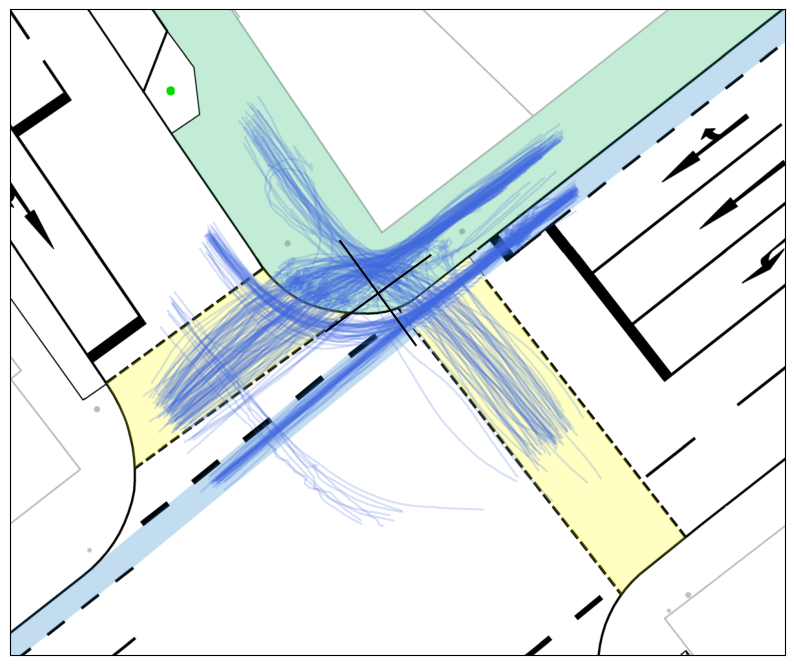

cooking plot:   0%|          | 0/41 [00:00<?, ?it/s]

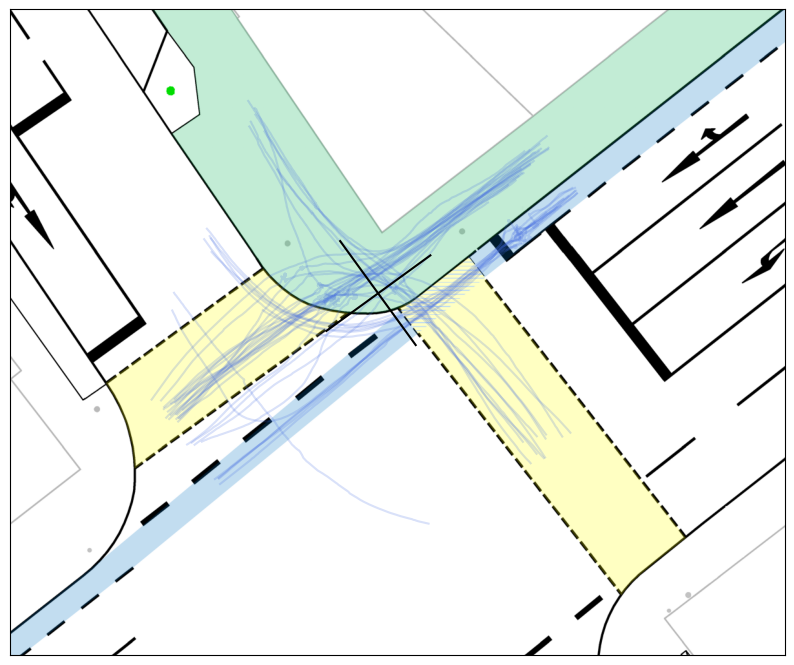

cooking plot:   0%|          | 0/71 [00:00<?, ?it/s]

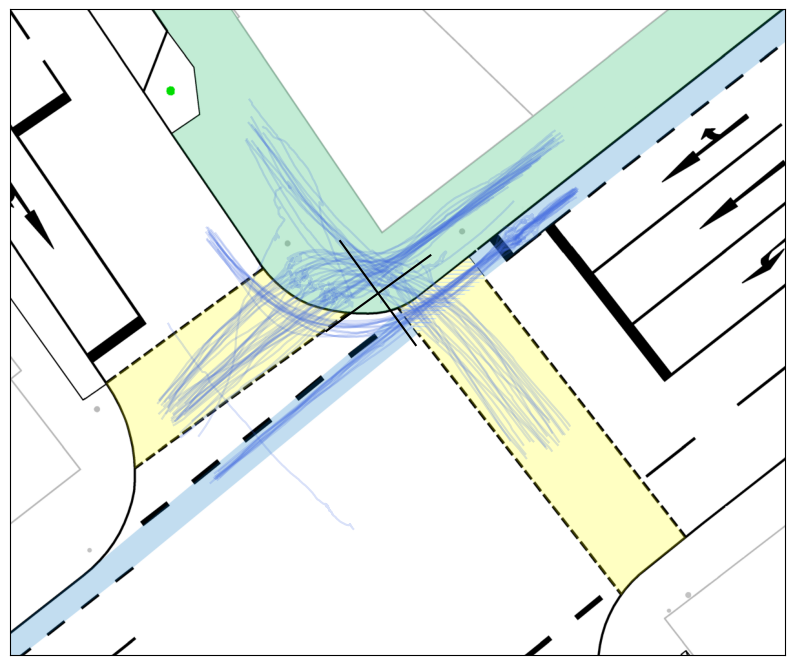

In [34]:
plot_traj_on_intersection(raw_train)
plot_traj_on_intersection(raw_val)
plot_traj_on_intersection(raw_test)

## Processing head trajectories and Dataloader

------------------

**Pre-Processing data**

>Scaling

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(raw_train)

#############################################

raw_train_scaled_ = scaler.transform(raw_train)
raw_train_scaled = pd.DataFrame(raw_train_scaled_, columns=raw_train.columns.values, index=raw_train.index)

targets_train_scaled_ = scaler.transform(targets_train)
targets_train_scaled = pd.DataFrame(targets_train_scaled_, columns=targets_train.columns.values, index=targets_train.index)

#############################################

raw_val_scaled_ = scaler.transform(raw_val)
raw_val_scaled = pd.DataFrame(raw_val_scaled_, columns=raw_val.columns.values, index=raw_val.index)

targets_val_scaled_ = scaler.transform(targets_val)
targets_val_scaled = pd.DataFrame(targets_val_scaled_, columns=targets_val.columns.values, index=targets_val.index)

#############################################

raw_test_scaled_ = scaler.transform(raw_test)
raw_test_scaled = pd.DataFrame(raw_test_scaled_, columns=raw_test.columns.values, index=raw_test.index)

targets_test_scaled_ = scaler.transform(targets_test)
targets_test_scaled = pd.DataFrame(targets_test_scaled_, columns=targets_test.columns.values, index=targets_test.index)

**Time Series Loader**

>In this special case of a `TimsSeriesData` class you can define the length of the segments using a time string value. 
    `'2s'`, `'5s'`, `'500ms'` etc.
    
>Choose one value to continue to the following experiments

In [36]:
sw = '5s' # TODO

train_data = TimeSeriesData(raw_train_scaled, y=targets_train_scaled, sw=sw)
val_data = TimeSeriesData(raw_val_scaled, y=targets_val_scaled, sw=sw)
test_data = TimeSeriesData(raw_test_scaled, y=targets_test_scaled, sw=sw)

>Number of segments available:

In [37]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

341286
48594
102659


>Now we can create the DataLoader instance setting a batch_size and number of workers for multi core processing

In [38]:
# for multicore processing
batch_size = 20 # TODO
num_workers = 8 # TODO

loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loader_val = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [39]:
# x_, y_ = next(iter(loader_train))
# print(x_.shape)
# print(y_.shape)

torch.Size([20, 250, 2])
torch.Size([20, 250, 2])


## Autoencoder

----------------------

**1)** Use the following class to create an Autoencoder Model.

>You can use the `nn.Sequential`module from PyTorch to define the structure of the encoder and the decoder

>Usually the structure of the decoder is a "mirrored" structure of de encoder. 

![](https://www.nbshare.io/static/snapshots/autoencoders_2.png)

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        """Implementation of Autoencoder
        Args:
            encoder (nn.Sequential): Encoder network.
            decoder (nn.Sequential): Decoder network.
        """
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encode(x)
        reconstruction = self.decode(z)
        return (reconstruction, z) # Forward returns reconstruction and [z] representation

    def encode(self, x):
        """Encode specific samples in to the laten representation"""
        z = self.encoder(x)
        return z

    def decode(self, z):
        """Return a reconstruction which is based on sample z."""
        recon = self.decoder(z)
        return recon

The following code helps you to create the encoder and decoder part

>Use at the beginning of the encoder [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to create a single vector as an input to the first layer

>At the end of the decoder use [`nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html) to expand the output of the last layer into a desired shape. (It requires mind. PyTorch 1.8) 

In [41]:
# print(next(iter(loader_train))[0].shape)

In [42]:
latent_dim = 5 # TODO
seq_length = train_data.n_steps # This provides you the number of points given in a segment
                                # Usefull for defining the number of inputs in the first fully connected layer of the AE
print(seq_length)
encoder = nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(seq_length*2, seq_length),
    torch.nn.ReLU(),
    torch.nn.Linear(seq_length, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, latent_dim),
    torch.nn.Identity(),
    
)

decoder = nn.Sequential(
    
    
    torch.nn.Linear(latent_dim, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, seq_length),
    torch.nn.ReLU(),
    torch.nn.Linear(seq_length, seq_length*2),
    torch.nn.Identity(),
    torch.nn.Unflatten(dim=1, unflattened_size=(seq_length, 2)),
)

250


Autoencoder initialization

In [43]:
autoencoder = AE(encoder, decoder)

In [44]:
# test

x_recon, z = autoencoder(x_)

print(x_recon.shape)
print(z.shape)

torch.Size([20, 250, 2])
torch.Size([20, 5])


In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoencoder.to(device)

AE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=500, out_features=250, bias=True)
    (2): ReLU()
    (3): Linear(in_features=250, out_features=120, bias=True)
    (4): ReLU()
    (5): Linear(in_features=120, out_features=5, bias=True)
    (6): Identity()
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=500, bias=True)
    (5): Identity()
    (6): Unflatten(dim=1, unflattened_size=(250, 2))
  )
)

## Training the Autoencoder

------

**2)** Which Loss is suitable in this case? Apply the corresponding loss function

In [47]:
lr = 1e-5
n_epochs = 5

print('Training on {}.'.format(device))
history = {'train_loss': []}

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=.1)

for i_epoch in range(n_epochs):
    running_loss = 0
    for X_batch, y_batch in tqdm(loader_train, desc=f'Epoch: {i_epoch + 1}', leave=False):
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Get latent dist, compute reconstruction and evaluate loss
        z = autoencoder.encode(X_batch)
        X_reconstruction = autoencoder.decode(z)
        
        loss = F.mse_loss(X_reconstruction, X_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += len(X_batch) * loss

    history['train_loss'].append((running_loss / len(loader_train)).item())
    print("[Ep {}] Loss: {:.5f}".format(i_epoch + 1, history['train_loss'][-1]))
    lr_scheduler.step()

Training on cpu.


Epoch: 1:   0%|          | 0/17065 [00:00<?, ?it/s]

[Ep 1] Loss: 0.72590


Epoch: 2:   0%|          | 0/17065 [00:00<?, ?it/s]

[Ep 2] Loss: 0.02996


Epoch: 3:   0%|          | 0/17065 [00:00<?, ?it/s]

[Ep 3] Loss: 0.01603


Epoch: 4:   0%|          | 0/17065 [00:00<?, ?it/s]

[Ep 4] Loss: 0.01291


Epoch: 5:   0%|          | 0/17065 [00:00<?, ?it/s]

[Ep 5] Loss: 0.01137


## Latent Space [z]

**3)** Plot the latent space of the evaluation set using one of the following options:

- [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) - here you require the installation of seaborn `conda install -c anaconda seaborn`
- [scatter_matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html)

>You need to iterate over all the evaluation set and store the z-latent representation at each iteration calculated from the autoencoder

In [48]:
latent_encodings = []
for X_batch, y_batch in tqdm(loader_val, desc=f'Epoch: {i_epoch + 1}', leave=False):
        autoencoder.eval()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Get latent dist, compute reconstruction and evaluate loss
        z = autoencoder.encode(X_batch)
        latent_encodings.append(z.detach().cpu().numpy())
        #X_reconstruction = autoencoder.decode(z)

Epoch: 5:   0%|          | 0/2430 [00:00<?, ?it/s]

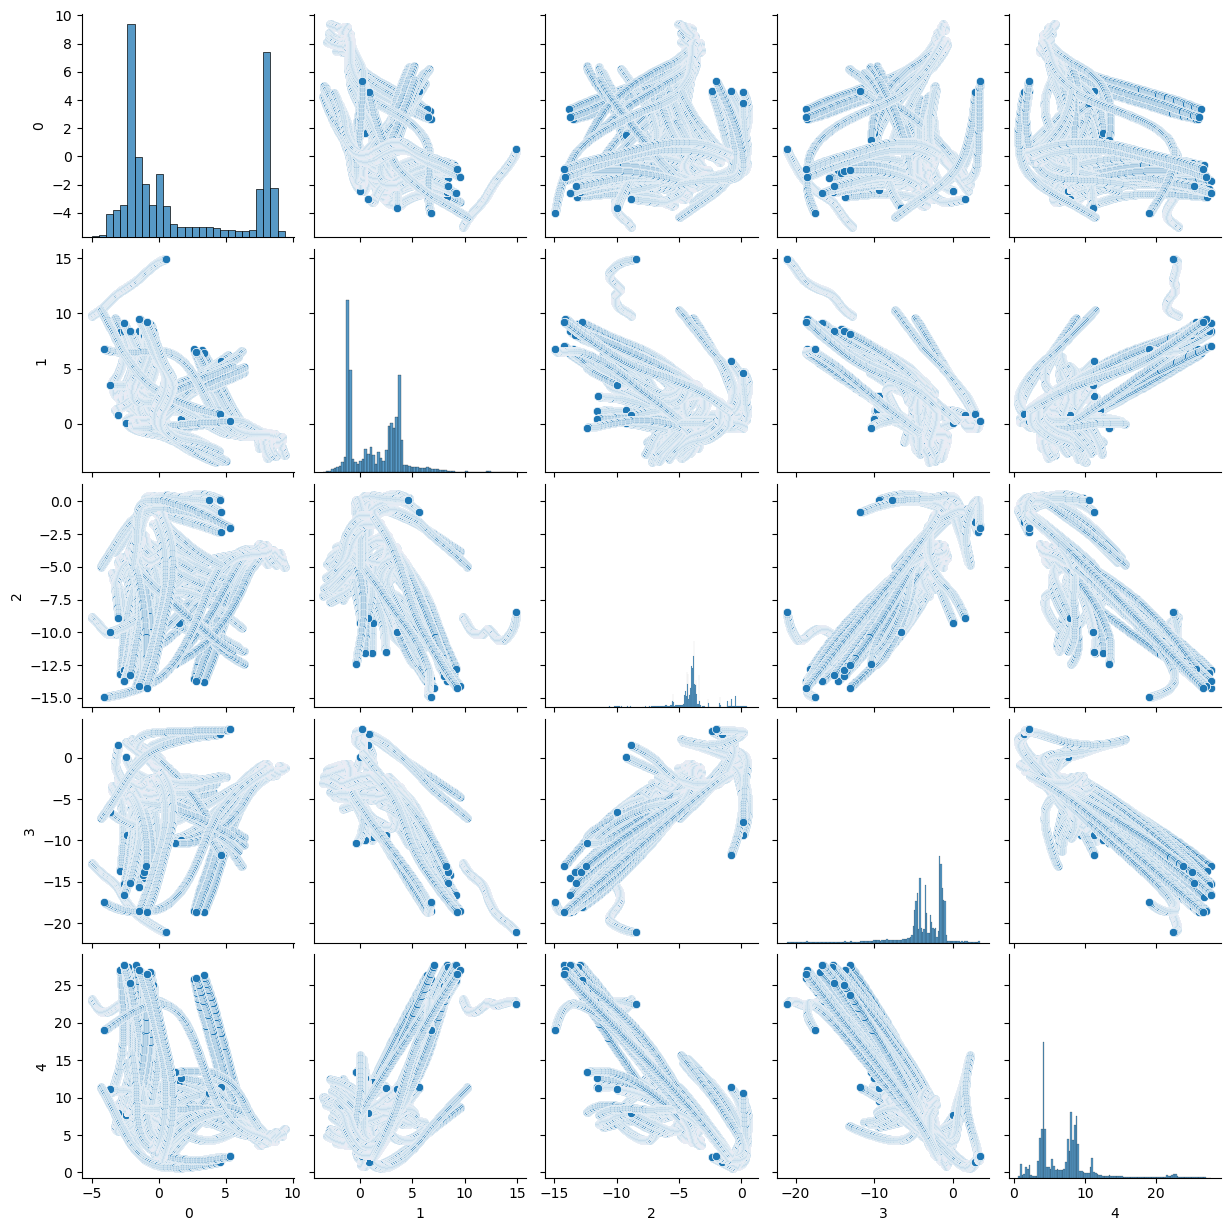

In [49]:
pairplot = sns.pairplot(pd.DataFrame(np.concatenate(latent_encodings, axis=0)))

Exp. evaluated:   0%|          | 0/18 [00:00<?, ?it/s]

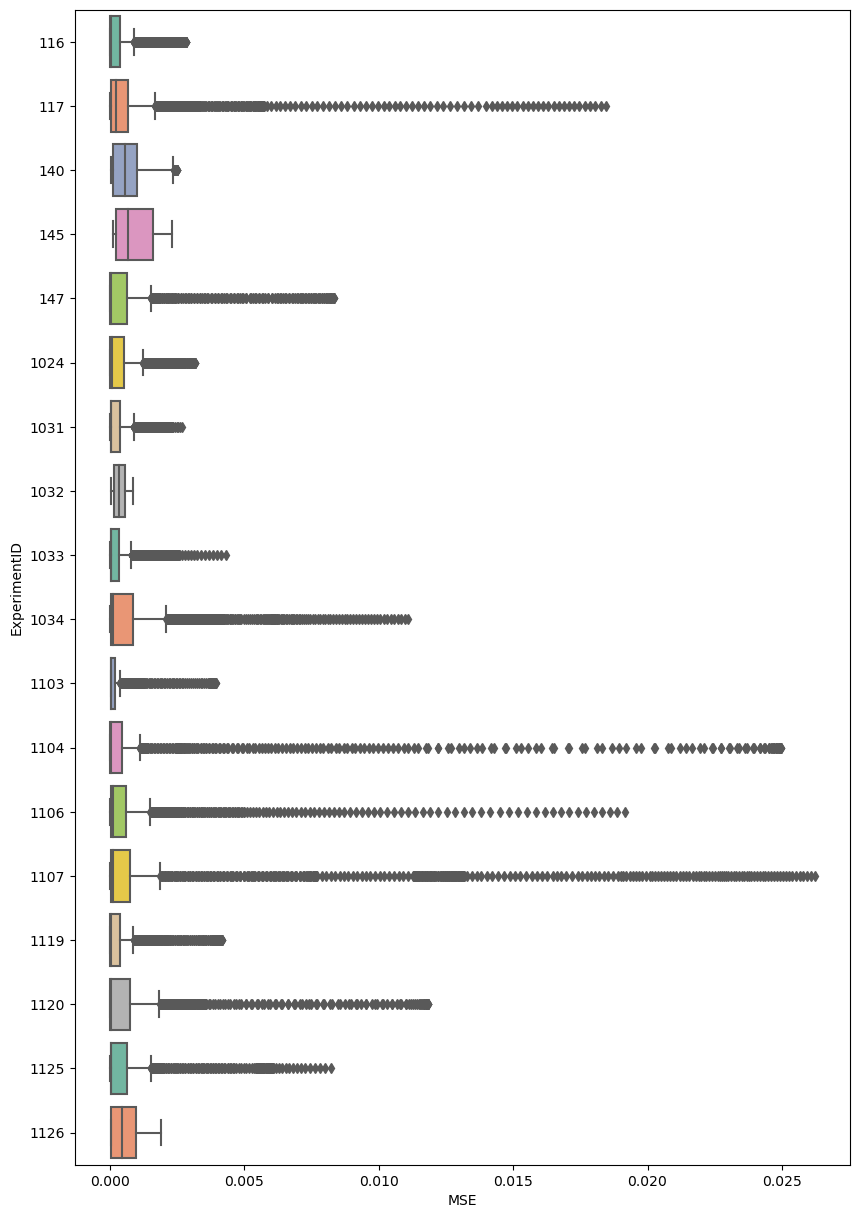

In [50]:
loss_exp_list, exp_list = evaluate_reconstruction(loader_val, autoencoder)

decoding batches:   0%|          | 0/5133 [00:00<?, ?it/s]

cooking plot ID:   0%|          | 0/102659 [00:00<?, ?it/s]

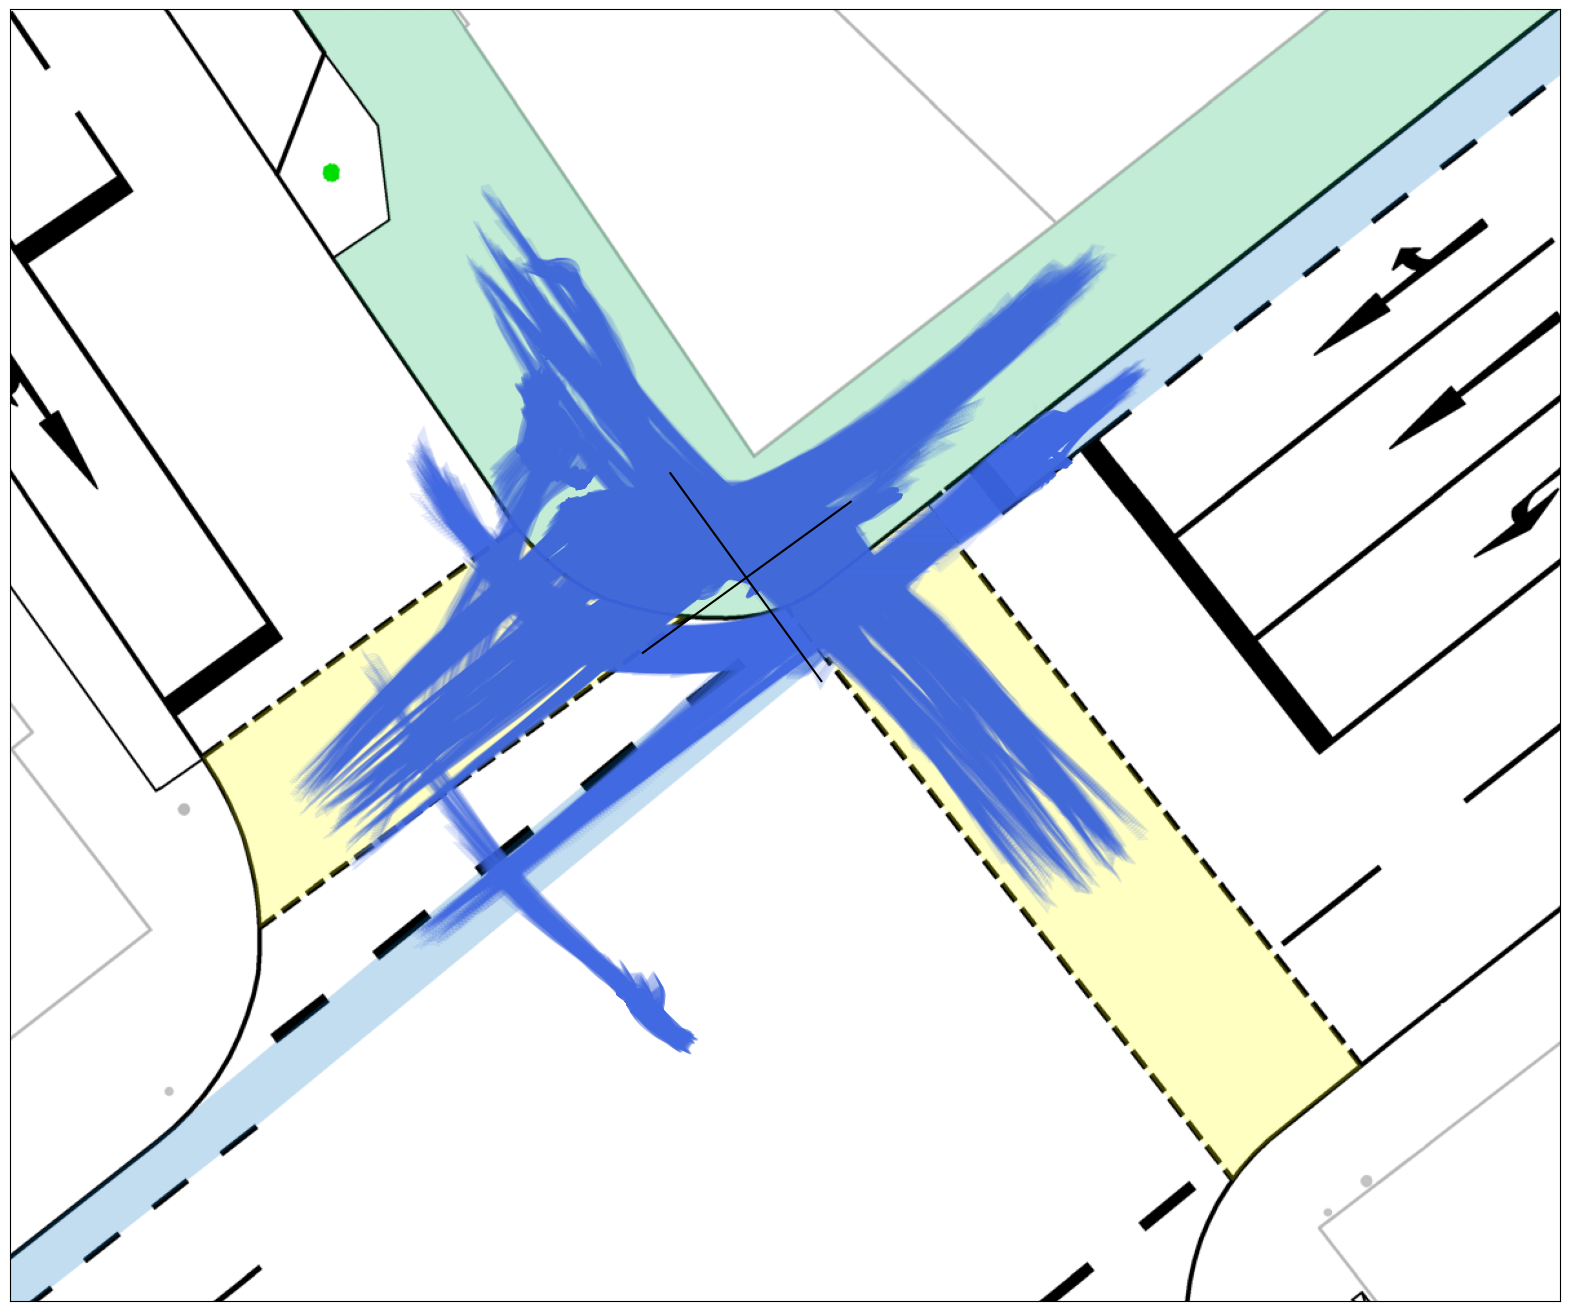

In [51]:
coordinates_list = plot_reconstruction_on_intersection(loader_test, autoencoder, scaler)

## Bonus Task

**1)** Train a Variational Autoencoder and explain the difference from an Autoencoder

**2)** Which Loss Function is required in this case?

**3)** How does the latent space look now? What is the difference from the Autoencoder?

# Anomaly Detection using VAE

Further Information about the Datasets: https://github.com/numenta/NAB

--------

**Normal data**

In [ ]:
data_path = "./data/artificialNoAnomaly/art_daily_small_noise.csv"
train_df = pd.read_csv(data_path).set_index('timestamp')

In [ ]:
train_df.plot(figsize=(8,5), title='Normal Data')

----------

**Abnormal data**

In [ ]:
os.listdir('./data/artificialWithAnomaly')

In [ ]:
test_df_list = []
for path_ in os.listdir('./data/artificialWithAnomaly'):
    test_df_list.append(pd.read_csv(os.path.join("./data/artificialWithAnomaly", path_)).set_index('timestamp'))

In [ ]:
fig, axs = plt.subplots(2, 3)
list_counter = 0
for i in np.arange(2):
    for j in np.arange(3):
        test_df_list[list_counter].plot(ax=axs[i,j], figsize=(15,10))
        list_counter += 1

**Scaling**

In [ ]:
standard_scaler = StandardScaler().fit(train_df)

t_scaled_ = standard_scaler.transform(train_df)
t_scaled_df = pd.DataFrame(t_scaled_, columns=train_df.columns.values, index=train_df.index)

test_scaled_df_list = []
for test_df in test_df_list:
    loc_val_ = standard_scaler.transform(test_df)
    test_scaled_df_list.append(pd.DataFrame(loc_val_, columns=test_df.columns.values, index=test_df.index))

**Dataloader**

In [ ]:
class SingleTimeSeriesData(Dataset):
    def __init__(self, X, sw):
               
        self.X = X.values # Time Series data
        self.timestamps = X.index
        self.sw = sw # window size of the sliding window
        
    def __len__(self):
        
        # The __len__ function returns the number of samples in our dataset
        # hint: you need to take into account the window size s
        
        return len(self.X) - self.sw
        
    def __get_segment__(self, X, index):
        
        # The split_sequence class returns the time series vector from the given index 
        # up to the given index plus the window size 
        # Additionaly it gives the realted class
        
        X_ =  X[index:index + self.sw].reshape(-1, 1)
        return X_
    
    def __getitem__(self, idx):  
    
        # The __getitem__ function returns a sample from the dataset at the given index idx
        # It should return it as a torch.Tensor class
        
        x_seq =  self.__get_segment__(self.X, idx)
        return torch.Tensor(x_seq).float().t()


In [ ]:
n = 50

train_dataset = SingleTimeSeriesData(t_scaled_df, sw=n)

In [ ]:
loader_train_dataset = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [ ]:
loader_test_list = []
for test_sc_ in test_scaled_df_list:
    loc_test_dataset= SingleTimeSeriesData(test_sc_, sw=n)
    loader_test_list.append(DataLoader(loc_test_dataset, batch_size=1, shuffle=False))

## VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, seq_length, latent_dim):
        
        super().__init__()
        
        hidden_size = 50

        self.fc1 = nn.Linear(seq_length, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, seq_length)
        self.unfl = nn.Unflatten(1, [1, seq_length])

    def encode(self, x):
        h1 = F.relu(self.fc1(x.flatten(1)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = self.fc4(h3)
        return self.unfl(h4)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
vae = VAE(n, latent_dim=5)
vae.to(device)

**Training the VAE**

In [ ]:
lr = 1e-5
beta = 1
n_epochs = 100

print('Training on {}.'.format(device))
history = {'train_loss': []}

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=.1)

for i_epoch in range(n_epochs):
    running_loss = 0
    for X_batch in tqdm(loader_train_dataset, desc=f'Epoch: {i_epoch + 1}', leave=False):
        
        X_batch = X_batch.to(device)

        X_recon, mu, logvar = vae(X_batch)
               
        MSE = F.mse_loss(X_recon, X_batch, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = MSE + beta*KLD
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += len(X_batch) * loss

    history['train_loss'].append((running_loss / len(loader_train_dataset)).item())
    print("[Ep {}] Loss: {:.5f}".format(i_epoch + 1, history['train_loss'][-1]))
    lr_scheduler.step()

In [ ]:
plt.figure()
plt.plot(history['train_loss'])
plt.title('Train Loss')
plt.show()

In [ ]:
z_latent_ = []
vae.eval()
for i_batch, batch in enumerate(loader_train_dataset):
    X_batch = batch.to(device)
    mu, var = vae.encode(X_batch)
    z = vae.reparameterize(mu, var)
    z_latent_.append(z.cpu().detach().numpy())
z_latent = np.vstack(z_latent_)

**Latent Space**

In [ ]:
z_df = pd.DataFrame(z_latent, columns=np.arange(1, z_latent.shape[1] + 1))
g = sns.pairplot(z_df, diag_kind='kde', markers='o')
#g.map_lower(sns.kdeplot, levels=8, color=".2")

**1)** Use the VAE to reconstruct the test data and plot the reconstruction error. What do you observe?

>Create a Dataloader for each test dataframe. 

>Save the reconstruction error for each segment in a list.

>Plot the values of the reconstruction errors considering the size of the segments over each of the test dataframes

**2)** Set a suitable threshold to the reconstruction error to identify outliers or anomalies in the test dataframes

**3)** Plot the results. In Which cases was possible to detect the abnormal instances? 

In [ ]:
####################
# Your Code Here   #
####################

In [ ]:
####################
# Your Code Here   #
####################